### Pembuatan Model Seluruh Pelabuhan

-

-

In [1]:
# define path
path = "dat_filtered/"

# import library data processing
import pandas as pd
import numpy as np

# import library for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# import self module
from prepare_load import *

# import ML library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

# pycaret regression
#from pycaret.regression import *
from pycaret.classification import *

In [2]:
# load kapal dataset
import xlrd
xlsx = xlrd.open_workbook(path+"dataframe_pivot_pelabuhan_v2.xlsx", on_demand=True)
sheet_names = xlsx.sheet_names()
print(sheet_names)
sheet_names.remove("All")

['All', 'KELAPA_HARAPAN', 'LANCANG', 'MARINA', 'ANGKE', 'PARI', 'PRAMUKA_PANGGANG', 'SABIRA', 'TIDUNG_PAYUNG', 'UNTUNG_JAWA']


In [3]:
# dictionary of kapa dataframe per pelabuhan
df_kapal = {item:pd.read_excel(path+"dataframe_pivot_pelabuhan_v2.xlsx", 
                               sheet_name=item) for item in sheet_names}

# dataframe of new case COVID-19 and Google Mobility
case_mobi_custom = pd.read_excel(path+"New_case_mobility_customDate.xlsx")

# check Shape
print("KELAPA_HARAPAN: ", df_kapal["KELAPA_HARAPAN"].shape)
print("Mobility and New Case custom: ", case_mobi_custom.shape)

KELAPA_HARAPAN:  (578, 14)
Mobility and New Case custom:  (578, 6)


In [4]:
def mobilityTRansform(list_a):
    list_out = []
    for item in list_a:
        if item>=0:
            list_out.append(1)
        elif item<0:
            list_out.append(0)
    return list_out

def labelTransform(list_a):
    import statistics
    before_pandemi = list_a[0:427]
    med_ = statistics.median(before_pandemi)
    list_label = [1 if item >= med_ else 0 for item in list_a]
    return list_label

In [5]:
# concat dataframe
df_cont = pd.DataFrame({})

for item in sheet_names:
    df_procc = df_kapal[item]
    df_procc = df_procc.rename(columns={"Level Pembatasan Darurat": "Level_Pembatasan_Darurat"})
    df_procc1 = df_procc[["Jumlah Penumpang", "Level_Pembatasan_Darurat"]]
    df_procc1 = df_procc1.copy()
    df_procc1["Jumlah Penumpang"] = df_procc1["Jumlah Penumpang"].astype(int)
    df_procc1["Positivity_rate_val"] = case_mobi_custom["Positivity_rate_val"].tolist()
    df_procc1["Retail_recreation"] = case_mobi_custom["retail_and_recreation_percent_change_from_baseline"].tolist()
    df_procc1["Transit_station"] = case_mobi_custom["transit_stations_percent_change_from_baseline"].tolist()
    
    df_procc1["Retail_recreation"]  = mobilityTRansform(df_procc1["Retail_recreation"].tolist())
    df_procc1["Is_normal"] = labelTransform(df_procc1["Jumlah Penumpang"].tolist())
    df_procc1 = df_procc1[["Positivity_rate_val", "Retail_recreation", "Level_Pembatasan_Darurat", "Is_normal"]]
    
    df_cont = pd.concat([df_cont, df_procc1], ignore_index=True)
    
print(df_cont.shape)
df_cont.head()

(5202, 4)


,Positivity_rate_val,Retail_recreation,Level_Pembatasan_Darurat,Is_normal
0,0.0,1,0,1
1,0.0,1,0,0
2,0.0,1,0,0
3,0.0,1,0,0
4,0.0,1,0,0


In [6]:
df_cont.tail()

,Positivity_rate_val,Retail_recreation,Level_Pembatasan_Darurat,Is_normal
5197,0.339970,0,1,0
5198,0.548921,0,1,0
5199,-0.304072,0,1,0
5200,-0.101691,0,1,0
5201,-0.036769,0,1,0


In [7]:
df_cont["Is_normal"].value_counts()

0    3171
1    2031
Name: Is_normal, dtype: int64

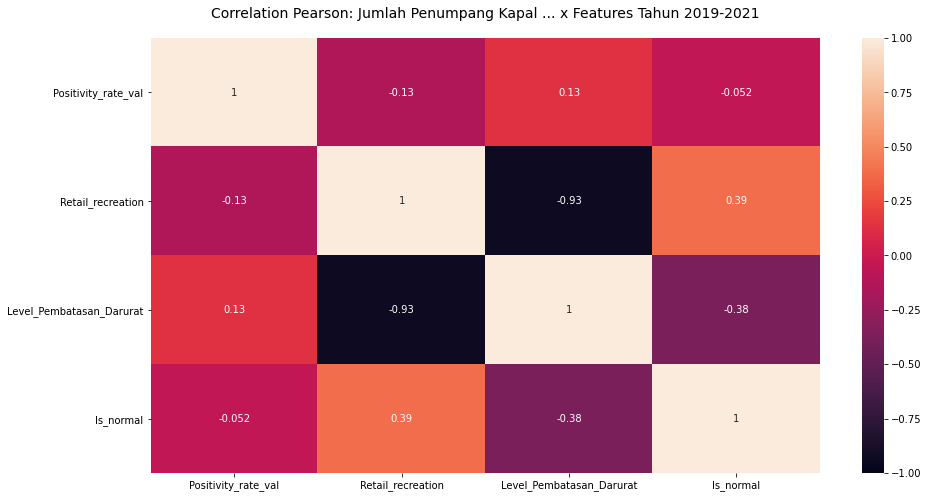

In [8]:
# Check Correlation
# visualize correlation pearson

plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(df_cont.corr(method="pearson"), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Pearson: Jumlah Penumpang Kapal ... x Features Tahun 2019-2021', fontdict={'fontsize':14}, pad=20);

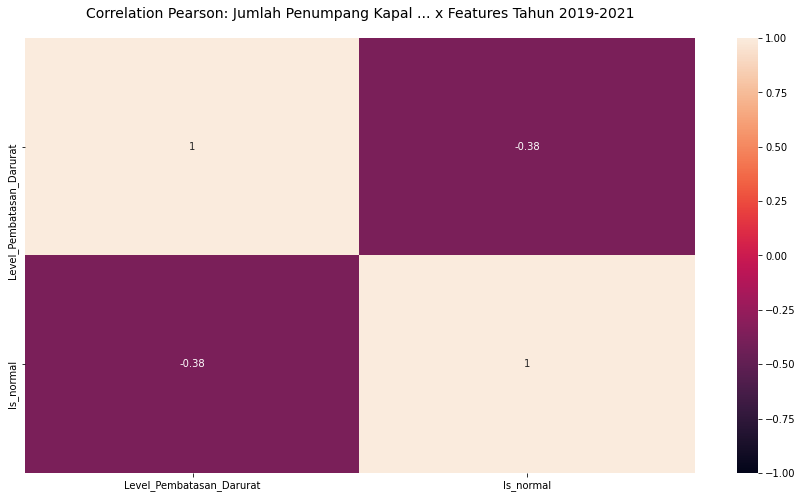

In [9]:
# Check Correlation
# visualize correlation pearson

df_orr = df_cont[["Level_Pembatasan_Darurat", "Is_normal"]]

plt.figure(figsize=(15, 8))

heatmap = sns.heatmap(df_orr.corr(method="pearson"), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Pearson: Jumlah Penumpang Kapal ... x Features Tahun 2019-2021', fontdict={'fontsize':14}, pad=20);

In [9]:
# check confidence of correlation
print("Check confidence of correlation")
model = ols("Is_normal ~ Level_Pembatasan_Darurat", data=df_cont).fit()
print(model.summary())

Check confidence of correlation
                            OLS Regression Results                            
Dep. Variable:              Is_normal   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     880.4
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          6.97e-179
Time:                        17:03:59   Log-Likelihood:                -3240.7
No. Observations:                5202   AIC:                             6485.
Df Residuals:                    5200   BIC:                             6499.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [10]:
# setup dataset
df_cont = df_cont.drop(['Level_Pembatasan_Darurat'], axis=1)


reg01 = setup(data=df_cont, target='Is_normal', session_id = 2228)

Setup Succesfully Completed!


,Description,Value
0,session_id,2228
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(5202, 3)"
4,Missing Values,False
5,Numeric Features,1
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [11]:
top3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Ada Boost Classifier,0.6166,0.6795,0.9451,0.5053,0.6584,0.3039,0.3863,0.1348
1,CatBoost Classifier,0.6166,0.6802,0.9451,0.5053,0.6584,0.3039,0.3863,2.9344
2,Gradient Boosting Classifier,0.6158,0.6797,0.9451,0.5047,0.6579,0.3027,0.3852,0.1368
3,Decision Tree Classifier,0.6147,0.6773,0.9451,0.5039,0.6573,0.3009,0.3837,0.0032
4,Extra Trees Classifier,0.6147,0.6773,0.9451,0.5039,0.6573,0.3009,0.3837,0.2139
5,Light Gradient Boosting Machine,0.6147,0.6775,0.9451,0.5039,0.6573,0.3009,0.3837,0.0835
6,Extreme Gradient Boosting,0.6144,0.6767,0.9451,0.5037,0.6571,0.3005,0.3833,0.1240
7,SVM - Linear Kernel,0.6133,0.0000,0.4719,0.2527,0.3291,0.1520,0.1930,0.0087
8,Naive Bayes,0.6130,0.6774,0.9472,0.5028,0.6568,0.2989,0.3830,0.0037
9,Random Forest Classifier,0.6130,0.6752,0.9451,0.5028,0.6563,0.2984,0.3815,0.1164


In [14]:
# create model
cm = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5918,0.6560,0.9580,0.4893,0.6478,0.2682,0.3625
1,0.6456,0.7041,0.9510,0.5271,0.6783,0.3494,0.4289
2,0.6071,0.6750,0.9577,0.4982,0.6554,0.2921,0.3837
3,0.6209,0.6851,0.9437,0.5076,0.6601,0.3101,0.3913
4,0.6538,0.7110,0.9648,0.5310,0.6850,0.3659,0.4507
5,0.5742,0.6431,0.9296,0.4765,0.6301,0.2360,0.3162
6,0.6099,0.6754,0.9366,0.5000,0.6520,0.2916,0.3712
7,0.6429,0.7039,0.9507,0.5233,0.6750,0.3458,0.4259
8,0.6126,0.6767,0.9155,0.5019,0.6484,0.2912,0.3600
9,0.6071,0.6713,0.9437,0.4981,0.6521,0.2890,0.3727


In [15]:
# tune model
tuned_ = tune_model(cm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5918,0.6567,0.9580,0.4893,0.6478,0.2682,0.3625
1,0.6456,0.7037,0.9510,0.5271,0.6783,0.3494,0.4289
2,0.6071,0.6734,0.9577,0.4982,0.6554,0.2921,0.3837
3,0.6209,0.6825,0.9437,0.5076,0.6601,0.3101,0.3913
4,0.6538,0.7095,0.9648,0.5310,0.6850,0.3659,0.4507
5,0.5742,0.6410,0.9296,0.4765,0.6301,0.2360,0.3162
6,0.6099,0.6731,0.9366,0.5000,0.6520,0.2916,0.3712
7,0.6429,0.7020,0.9507,0.5233,0.6750,0.3458,0.4259
8,0.6126,0.6757,0.9155,0.5019,0.6484,0.2912,0.3600
9,0.6071,0.6689,0.9437,0.4981,0.6521,0.2890,0.3727


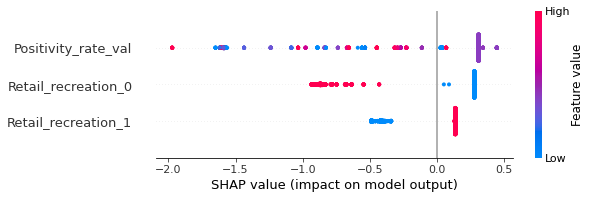

In [16]:
interpret_model(tuned_)

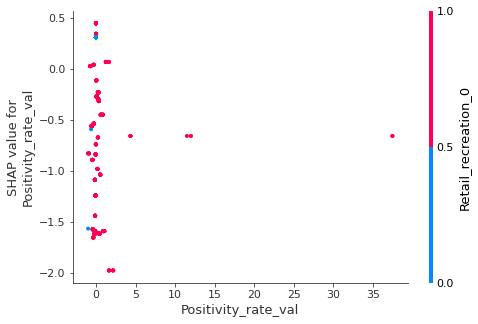

In [17]:
interpret_model(tuned_, plot = 'correlation')

In [18]:
# predict test set
dff_output = predict_model(tuned_)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.6156,0.6805,0.9622,0.5039,0.6614,0.306,0.3986


In [19]:
dff_output.head()

,Positivity_rate_val,Retail_recreation_0,Retail_recreation_1,Is_normal,Label,Score
0,0.000000,0.0,1.0,1,1,0.5054
1,-0.455090,1.0,0.0,1,0,0.0657
2,0.000000,0.0,1.0,1,1,0.5054
3,0.000000,0.0,1.0,1,1,0.5054
4,-0.315315,1.0,0.0,0,0,0.0286


In [20]:
# predict, evaluate
from sklearn.metrics import classification_report

print(classification_report(dff_output['Is_normal'], dff_output['Label']))

              precision    recall  f1-score   support

           0       0.94      0.39      0.56       952
           1       0.50      0.96      0.66       609

    accuracy                           0.62      1561
   macro avg       0.72      0.68      0.61      1561
weighted avg       0.77      0.62      0.60      1561



-ini

In [21]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [22]:
df_apri = df_cont[["Retail_recreation", "Is_normal"]]

frequent_itemsets = apriori(df_apri, min_support=0.01, use_colnames=True)

In [23]:
frequent_itemsets = frequent_itemsets.sort_values(by=['support'], ascending=False)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Retail_recreation),(Is_normal),0.740484,0.390427,0.37178,0.502077,1.285969,0.082675,1.224232
1,(Is_normal),(Retail_recreation),0.390427,0.740484,0.37178,0.952240,1.285969,0.082675,5.433774
